In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<AxesSubplot:xlabel='quality', ylabel='count'>

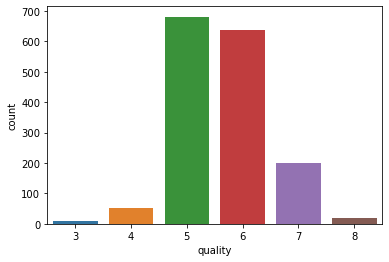

In [3]:
sns.countplot(x = 'quality', data=df)

In [4]:
class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

idx2class = {v: k for k, v in class2idx.items()}

df['quality'].replace(class2idx, inplace=True)

In [5]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [6]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [8]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict


Text(0.5, 1.0, 'Class Distribution in Test Set')

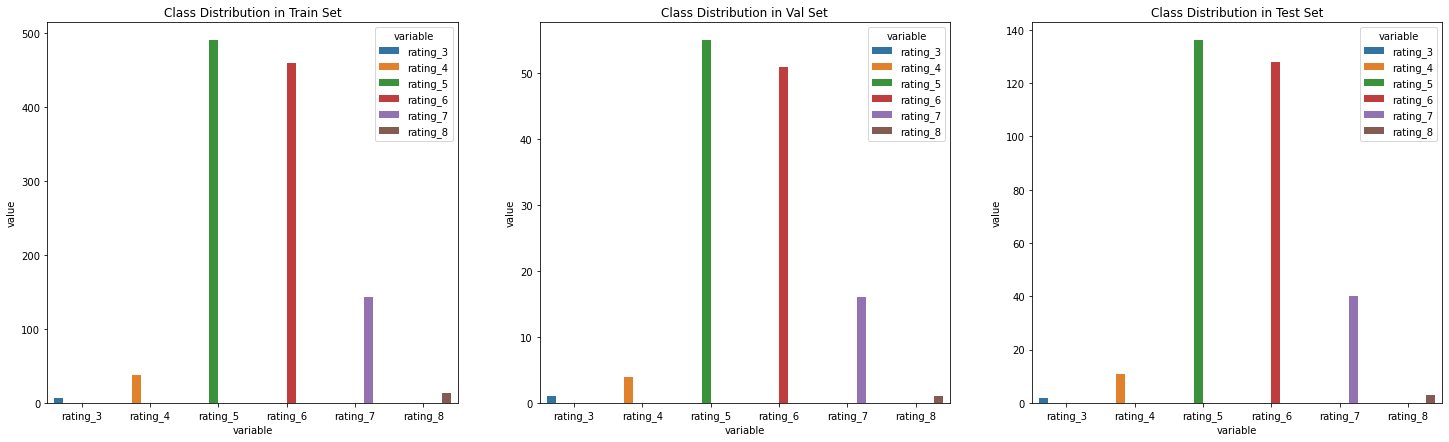

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [10]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [11]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [12]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.1429, 0.0263, 0.0020, 0.0022, 0.0070, 0.0714])


In [13]:
class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [14]:
EPOCHS = 3
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

In [15]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [16]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [18]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [19]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc


In [20]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [21]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        print(X_train_batch)
        print(y_train_batch)
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/3 [00:00<?, ?it/s]

tensor([[0.4455, 0.7671, 0.3400, 0.0753, 0.1119, 0.4627, 0.5124, 0.5822, 0.3228,
         0.1198, 0.1692],
        [0.2182, 0.3219, 0.2600, 0.0753, 0.1135, 0.2388, 0.3463, 0.4236, 0.4252,
         0.1138, 0.2308],
        [0.3545, 0.2192, 0.4900, 0.1301, 0.1185, 0.2537, 0.3710, 0.5969, 0.4409,
         0.1617, 0.1692],
        [0.1727, 0.4863, 0.0900, 0.0616, 0.1035, 0.0448, 0.0671, 0.3869, 0.5039,
         0.0719, 0.1846],
        [0.5455, 0.2808, 0.4900, 0.2534, 0.1770, 0.1343, 0.0389, 0.7438, 0.2598,
         0.1377, 0.5077],
        [0.1818, 0.4418, 0.1800, 0.1027, 0.3856, 0.0672, 0.1484, 0.4442, 0.5197,
         0.1617, 0.2923],
        [0.4636, 0.3014, 0.2400, 0.0890, 0.1119, 0.2687, 0.1837, 0.6630, 0.3465,
         0.1377, 0.2615],
        [0.4818, 0.0822, 0.4900, 0.1027, 0.1052, 0.1343, 0.0777, 0.5675, 0.3150,
         0.1677, 0.3077],
        [0.2727, 0.1507, 0.4200, 0.0753, 0.1235, 0.1045, 0.0459, 0.3957, 0.4803,
         0.1617, 0.4615],
        [0.5000, 0.2192, 0.7300, 0.38

tensor([[0.3000, 0.1575, 0.3300, 0.1027, 0.1068, 0.1493, 0.1449, 0.4347, 0.4173,
         0.2874, 0.4000],
        [0.2545, 0.5445, 0.1200, 0.0890, 0.2187, 0.0896, 0.0601, 0.4648, 0.4803,
         0.1916, 0.2769],
        [0.5182, 0.6199, 0.4300, 0.1301, 0.1135, 0.2985, 0.2756, 0.6189, 0.2520,
         0.1437, 0.2615],
        [0.1727, 0.4863, 0.0900, 0.0616, 0.1035, 0.0448, 0.0671, 0.3869, 0.5039,
         0.0719, 0.1846],
        [0.2727, 0.1507, 0.4200, 0.0753, 0.1235, 0.1045, 0.0459, 0.3957, 0.4803,
         0.1617, 0.4615],
        [0.2545, 0.3562, 0.2100, 0.0890, 0.1085, 0.4627, 0.4488, 0.4060, 0.4173,
         0.0719, 0.2308],
        [0.4364, 0.1199, 0.4000, 0.0411, 0.1018, 0.1940, 0.0530, 0.4031, 0.3150,
         0.1078, 0.3846],
        [0.4818, 0.0822, 0.4900, 0.1027, 0.1052, 0.1343, 0.0777, 0.5675, 0.3150,
         0.1677, 0.3077],
        [0.3727, 0.3151, 0.2500, 0.1301, 0.1052, 0.1194, 0.3463, 0.5668, 0.3858,
         0.1437, 0.2000],
        [0.2545, 0.5582, 0.4300, 0.08

tensor([[0.3091, 0.2123, 0.3000, 0.1712, 0.1119, 0.0896, 0.0989, 0.5734, 0.4882,
         0.1677, 0.3231],
        [0.4818, 0.0822, 0.4900, 0.1027, 0.1052, 0.1343, 0.0777, 0.5675, 0.3150,
         0.1677, 0.3077],
        [0.3727, 0.2123, 0.3400, 0.1096, 0.1135, 0.3731, 0.2827, 0.6336, 0.5039,
         0.1737, 0.1692],
        [0.3000, 0.2671, 0.2400, 0.0753, 0.1119, 0.2239, 0.2827, 0.5558, 0.4724,
         0.1856, 0.1692],
        [0.0818, 0.1164, 0.2600, 0.0548, 0.0851, 0.0299, 0.0177, 0.1050, 0.5118,
         0.1257, 0.7846],
        [0.2909, 0.1438, 0.4400, 0.0411, 0.0501, 0.0746, 0.0212, 0.3928, 0.4803,
         0.1677, 0.3538],
        [0.2545, 0.3904, 0.2200, 0.0685, 0.1202, 0.2537, 0.3110, 0.4427, 0.4488,
         0.0898, 0.1692],
        [0.2000, 0.3219, 0.0100, 0.0959, 0.1135, 0.3881, 0.1307, 0.3987, 0.5354,
         0.1497, 0.3538],
        [0.3727, 0.3699, 0.1700, 0.1438, 0.1085, 0.0597, 0.0247, 0.5529, 0.4331,
         0.1317, 0.3077],
        [0.3818, 0.1164, 0.3300, 0.07

tensor([[0.2545, 0.3562, 0.2100, 0.0890, 0.1085, 0.4627, 0.4488, 0.4060, 0.4173,
         0.0719, 0.2308],
        [0.2455, 0.2123, 0.4000, 0.1233, 0.1169, 0.0746, 0.0177, 0.3899, 0.5512,
         0.1257, 0.5846],
        [0.4182, 0.3014, 0.3300, 0.1027, 0.1285, 0.5075, 0.2155, 0.5235, 0.4252,
         0.2395, 0.5231],
        [0.4091, 0.3870, 0.1100, 0.1233, 0.1085, 0.0746, 0.0883, 0.6116, 0.3543,
         0.2216, 0.2615],
        [0.2182, 0.2260, 0.3600, 0.3425, 0.1035, 0.1642, 0.2862, 0.5675, 0.4646,
         0.2994, 0.3231],
        [0.3727, 0.3151, 0.2500, 0.1301, 0.1052, 0.1194, 0.3463, 0.5668, 0.3858,
         0.1437, 0.2000],
        [0.2273, 0.3219, 0.0800, 0.2397, 0.1235, 0.0746, 0.0813, 0.5382, 0.5039,
         0.1018, 0.0923],
        [0.3727, 0.1644, 0.5200, 0.0822, 0.1653, 0.0597, 0.0141, 0.4119, 0.4488,
         0.1737, 0.4462],
        [0.3818, 0.4623, 0.0000, 0.1164, 0.1402, 0.1493, 0.0707, 0.6850, 0.4803,
         0.2994, 0.1538],
        [0.3000, 0.2671, 0.2400, 0.07

tensor([[0.4727, 0.1096, 0.4600, 0.0616, 0.0634, 0.0597, 0.0247, 0.5382, 0.2362,
         0.2754, 0.2769],
        [0.4818, 0.2534, 0.6300, 0.1370, 0.1002, 0.1343, 0.0707, 0.4941, 0.3307,
         0.2695, 0.6308],
        [0.4727, 0.1027, 0.5400, 0.0959, 0.0885, 0.0896, 0.0707, 0.3847, 0.3386,
         0.1198, 0.6308],
        [0.3636, 0.1918, 0.5100, 0.1164, 0.0668, 0.1791, 0.0742, 0.3620, 0.4567,
         0.3413, 0.7692],
        [0.3909, 0.1986, 0.5000, 0.1096, 0.0718, 0.1642, 0.0671, 0.3767, 0.4724,
         0.2754, 0.7538],
        [0.2545, 0.3562, 0.2100, 0.0890, 0.1085, 0.4627, 0.4488, 0.4060, 0.4173,
         0.0719, 0.2308],
        [0.2818, 0.3082, 0.2300, 0.1575, 0.1018, 0.2388, 0.3993, 0.4905, 0.4094,
         0.1437, 0.1385],
        [0.1909, 0.2671, 0.0900, 0.0822, 0.0835, 0.0448, 0.0106, 0.4236, 0.4803,
         0.1257, 0.3231],
        [0.4273, 0.3014, 0.2300, 0.1712, 0.1503, 0.5373, 0.3039, 0.6997, 0.4409,
         0.1916, 0.2615],
        [0.4273, 0.1438, 0.5200, 0.08

tensor([3, 3, 1, 3, 4, 1, 3, 3, 5, 4, 2, 3, 2, 2, 4, 3])
tensor([[0.1091, 0.1781, 0.1500, 0.0616, 0.1002, 0.0746, 0.0459, 0.3987, 0.5354,
         0.1437, 0.1538],
        [0.3636, 0.1301, 0.5700, 0.0753, 0.1653, 0.3731, 0.2792, 0.5162, 0.4094,
         0.1198, 0.2000],
        [0.4818, 0.0822, 0.4900, 0.1027, 0.1052, 0.1343, 0.0777, 0.5675, 0.3150,
         0.1677, 0.3077],
        [0.3091, 0.4007, 0.1200, 0.1164, 0.1336, 0.1642, 0.0777, 0.6850, 0.6063,
         0.2335, 0.2462],
        [0.4000, 0.4486, 0.2700, 0.1301, 0.1102, 0.3433, 0.1767, 0.6116, 0.4488,
         0.2036, 0.3385],
        [0.3636, 0.1918, 0.5100, 0.1164, 0.0668, 0.1791, 0.0742, 0.3620, 0.4567,
         0.3413, 0.7692],
        [0.4909, 0.2808, 0.4800, 0.1096, 0.0851, 0.0746, 0.0671, 0.7144, 0.2992,
         0.1557, 0.1385],
        [0.3000, 0.4178, 0.2100, 0.0548, 0.1035, 0.0597, 0.0247, 0.4941, 0.3622,
         0.1138, 0.1692],
        [0.5000, 0.1438, 0.6300, 0.1301, 0.1202, 0.0597, 0.0565, 0.7144, 0.4094,
      

tensor([[0.2273, 0.2808, 0.2600, 0.0753, 0.1486, 0.2239, 0.2332, 0.4134, 0.3228,
         0.1437, 0.1538],
        [0.2818, 0.4281, 0.5600, 0.0753, 0.1770, 0.4328, 0.4523, 0.4941, 0.3937,
         0.1976, 0.1538],
        [0.3727, 0.2123, 0.3400, 0.1096, 0.1135, 0.3731, 0.2827, 0.6336, 0.5039,
         0.1737, 0.1692],
        [0.4636, 0.3014, 0.2400, 0.0890, 0.1119, 0.2687, 0.1837, 0.6630, 0.3465,
         0.1377, 0.2615],
        [0.3091, 0.2877, 0.2800, 0.0685, 0.1085, 0.1493, 0.1201, 0.5675, 0.5118,
         0.1677, 0.2462],
        [0.2727, 0.3699, 0.0000, 0.0342, 0.1402, 0.0746, 0.0247, 0.4126, 0.5433,
         0.1497, 0.1692],
        [0.3727, 0.2123, 0.3400, 0.1096, 0.1135, 0.3731, 0.2827, 0.6336, 0.5039,
         0.1737, 0.1692],
        [0.4000, 0.3664, 0.2600, 0.0753, 0.1402, 0.0597, 0.1025, 0.5367, 0.4016,
         0.0539, 0.1846],
        [0.2545, 0.4486, 0.4200, 0.0685, 0.1336, 0.1045, 0.2827, 0.4280, 0.3858,
         0.1557, 0.1692],
        [0.3000, 0.3973, 0.2300, 0.07

tensor([[0.4818, 0.0822, 0.4900, 0.1027, 0.1052, 0.1343, 0.0777, 0.5675, 0.3150,
         0.1677, 0.3077],
        [0.3091, 0.4007, 0.1200, 0.1164, 0.1336, 0.1642, 0.0777, 0.6850, 0.6063,
         0.2335, 0.2462],
        [0.3182, 0.4281, 0.1100, 0.0685, 0.1302, 0.2239, 0.2014, 0.4721, 0.3543,
         0.2934, 0.1846],
        [0.2727, 0.2671, 0.2500, 0.1370, 0.1085, 0.2985, 0.1378, 0.5382, 0.5906,
         0.3772, 0.5692],
        [0.3182, 0.1712, 0.5300, 0.0616, 0.6694, 0.1194, 0.0707, 0.5749, 0.2520,
         0.4371, 0.1077],
        [0.2091, 0.3493, 0.0300, 0.0890, 0.1135, 0.2388, 0.2898, 0.5419, 0.6220,
         0.1497, 0.2154],
        [0.3727, 0.2123, 0.3400, 0.1096, 0.1135, 0.3731, 0.2827, 0.6336, 0.5039,
         0.1737, 0.1692],
        [0.6636, 0.2260, 0.4900, 0.0342, 0.1052, 0.0299, 0.0000, 0.5015, 0.3071,
         0.1796, 0.3077],
        [0.2727, 0.3904, 0.2100, 0.0822, 0.1135, 0.4776, 0.4770, 0.4501, 0.4016,
         0.1078, 0.2308],
        [0.0818, 0.3836, 0.0200, 0.06

tensor([[0.1182, 0.1644, 0.2400, 0.0890, 0.1386, 0.2687, 0.1272, 0.3326, 0.6535,
         0.1437, 0.5077],
        [0.2364, 0.2671, 0.0200, 0.0548, 0.1202, 0.1791, 0.0883, 0.3899, 0.4882,
         0.1257, 0.3231],
        [0.2818, 0.3288, 0.0800, 0.1164, 0.0735, 0.0299, 0.0035, 0.2048, 0.3780,
         0.0240, 0.7077],
        [0.1000, 0.1438, 0.3200, 0.8219, 0.0701, 0.0746, 0.3781, 0.4148, 0.4409,
         0.1377, 0.4769],
        [0.1455, 0.2329, 0.1400, 0.1027, 0.1703, 0.1194, 0.1095, 0.5323, 0.7244,
         0.1916, 0.2154],
        [0.3818, 0.1096, 0.4800, 0.0616, 0.0918, 0.3731, 0.1413, 0.4868, 0.4567,
         0.4251, 0.3385],
        [0.2909, 0.4521, 0.2300, 0.1164, 0.0785, 0.0597, 0.0318, 0.5088, 0.4961,
         0.1377, 0.4462],
        [0.4273, 0.3014, 0.2300, 0.1712, 0.1503, 0.5373, 0.3039, 0.6997, 0.4409,
         0.1916, 0.2615],
        [0.3182, 0.0890, 0.3900, 0.0753, 0.0484, 0.0448, 0.0141, 0.2783, 0.4173,
         0.2275, 0.6308],
        [0.4000, 0.1644, 0.3900, 0.04

tensor([[0.3000, 0.1575, 0.3300, 0.1027, 0.1068, 0.1493, 0.1449, 0.4347, 0.4173,
         0.2874, 0.4000],
        [0.7636, 0.1507, 0.5200, 0.1575, 0.1369, 0.2388, 0.1661, 0.8319, 0.2441,
         0.2874, 0.1692],
        [0.4818, 0.0822, 0.4900, 0.1027, 0.1052, 0.1343, 0.0777, 0.5675, 0.3150,
         0.1677, 0.3077],
        [0.2818, 0.4281, 0.5600, 0.0753, 0.1770, 0.4328, 0.4523, 0.4941, 0.3937,
         0.1976, 0.1538],
        [0.4909, 0.1986, 0.4200, 0.1027, 0.3356, 0.0746, 0.0283, 0.6850, 0.3543,
         0.1737, 0.1692],
        [0.3818, 0.1096, 0.4800, 0.0616, 0.0918, 0.3731, 0.1413, 0.4868, 0.4567,
         0.4251, 0.3385],
        [0.4000, 0.3664, 0.2600, 0.0753, 0.1402, 0.0597, 0.1025, 0.5367, 0.4016,
         0.0539, 0.1846],
        [0.3636, 0.1301, 0.3600, 0.1164, 0.0735, 0.1343, 0.1166, 0.4075, 0.5197,
         0.2156, 0.5231],
        [0.3727, 0.2123, 0.3400, 0.1096, 0.1135, 0.3731, 0.2827, 0.6336, 0.5039,
         0.1737, 0.1692],
        [0.3455, 0.2877, 0.2600, 0.10

tensor([[0.4182, 0.2329, 0.4900, 0.3699, 0.0868, 0.0597, 0.0389, 0.6410, 0.3701,
         0.2395, 0.4000],
        [0.4818, 0.1164, 0.4900, 0.1164, 0.0785, 0.0597, 0.0247, 0.5529, 0.2441,
         0.2455, 0.3231],
        [0.2636, 0.2603, 0.3000, 0.0685, 0.1052, 0.1045, 0.0565, 0.4280, 0.4488,
         0.1377, 0.3077],
        [0.4545, 0.2877, 0.4500, 0.0959, 0.0985, 0.2239, 0.1201, 0.6630, 0.5118,
         0.1737, 0.1538],
        [0.1455, 0.2329, 0.1400, 0.1027, 0.1703, 0.1194, 0.1095, 0.5323, 0.7244,
         0.1916, 0.2154],
        [0.2000, 0.1507, 0.2800, 0.0753, 0.1169, 0.4478, 0.2191, 0.5044, 0.5591,
         0.0898, 0.1538],
        [0.3818, 0.1096, 0.4800, 0.0616, 0.0918, 0.3731, 0.1413, 0.4868, 0.4567,
         0.4251, 0.3385],
        [0.3545, 0.1986, 0.6400, 0.0890, 0.1352, 0.1194, 0.1272, 0.6263, 0.6299,
         0.1976, 0.3231],
        [0.0727, 0.6918, 0.0900, 0.0411, 0.2671, 0.0896, 0.0459, 0.2885, 0.5984,
         0.0898, 0.2154],
        [0.3000, 0.1575, 0.3300, 0.10

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

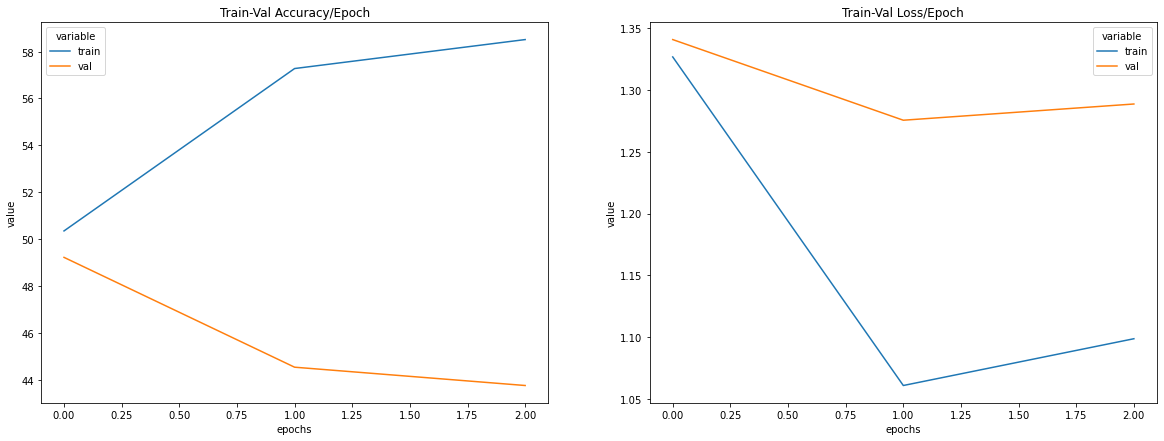

In [22]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [23]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

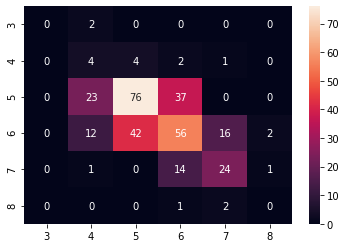

In [24]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [25]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.10      0.36      0.15        11
           2       0.62      0.56      0.59       136
           3       0.51      0.44      0.47       128
           4       0.56      0.60      0.58        40
           5       0.00      0.00      0.00         3

    accuracy                           0.50       320
   macro avg       0.30      0.33      0.30       320
weighted avg       0.54      0.50      0.52       320



/Users/maoss2/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maoss2/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maoss2/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from multiomic_modeling.data.data_loader import MultiomicDataset, SubsetRandomSampler, multiomic_dataset_builder

dataset = MultiomicDataset()
train, valid, test = multiomic_dataset_builder(dataset=dataset, test_size=0.2, valid_size=0.1)
class_weights = dataset.class_weights

target_list = dataset.all_patient_labels
target_list = torch.Tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))].int()

class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
EPOCHS = 12
BATCH_SIZE = 64
LEARNING_RATE = 1e-3 # 0.0007
NUM_FEATURES = 16000
NUM_CLASSES = 33
train_loader = DataLoader(dataset=train,
                          batch_size=BATCH_SIZE,
                          sampler=SubsetRandomSampler(np.arange(len(train)))
)
val_loader = DataLoader(dataset=valid, batch_size=16, sampler=SubsetRandomSampler(np.arange(len(valid))))
test_loader = DataLoader(dataset=test, batch_size=1, sampler=SubsetRandomSampler(np.arange(len(test))))

class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

print("Begin training.")
model = model.float()
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        # print(torch.Tensor.unique(y_train_batch))
        y_train_pred = model(X_train_batch.float())
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch.float())
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

/Users/maoss2/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32], y=[ 0  0  0 ... 32 32 32] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
  0%|          | 0/12 [00:00<?, ?it/s]

cpu
MulticlassClassification(
  (layer_1): Linear(in_features=16000, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=33, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Begin training.


  8%|▊         | 1/12 [00:14<02:34, 14.03s/it]

Epoch 001: | Train Loss: 1.63025 | Val Loss: 0.59713 | Train Acc: 71.105| Val Acc: 91.204


 17%|█▋        | 2/12 [00:28<02:20, 14.04s/it]

Epoch 002: | Train Loss: 0.47022 | Val Loss: 0.24035 | Train Acc: 92.045| Val Acc: 94.537


 25%|██▌       | 3/12 [00:42<02:06, 14.05s/it]

Epoch 003: | Train Loss: 0.23624 | Val Loss: 0.17450 | Train Acc: 94.436| Val Acc: 95.646


 33%|███▎      | 4/12 [00:56<01:52, 14.07s/it]

Epoch 004: | Train Loss: 0.17870 | Val Loss: 0.16139 | Train Acc: 95.414| Val Acc: 95.667


 42%|████▏     | 5/12 [01:10<01:39, 14.16s/it]

Epoch 005: | Train Loss: 0.13429 | Val Loss: 0.13762 | Train Acc: 96.571| Val Acc: 96.231


 50%|█████     | 6/12 [01:24<01:25, 14.21s/it]

Epoch 006: | Train Loss: 0.08302 | Val Loss: 0.14659 | Train Acc: 97.594| Val Acc: 96.639


 58%|█████▊    | 7/12 [01:39<01:11, 14.27s/it]

Epoch 007: | Train Loss: 0.07468 | Val Loss: 0.13770 | Train Acc: 97.729| Val Acc: 96.265


 67%|██████▋   | 8/12 [01:53<00:57, 14.34s/it]

Epoch 008: | Train Loss: 0.05244 | Val Loss: 0.11181 | Train Acc: 98.474| Val Acc: 97.000


 75%|███████▌  | 9/12 [02:08<00:43, 14.36s/it]

Epoch 009: | Train Loss: 0.04513 | Val Loss: 0.17116 | Train Acc: 98.880| Val Acc: 95.857


 83%|████████▎ | 10/12 [02:22<00:28, 14.39s/it]

Epoch 010: | Train Loss: 0.03391 | Val Loss: 0.13496 | Train Acc: 99.128| Val Acc: 97.014


 92%|█████████▏| 11/12 [02:36<00:14, 14.35s/it]

Epoch 011: | Train Loss: 0.03275 | Val Loss: 0.14664 | Train Acc: 99.045| Val Acc: 96.646


100%|██████████| 12/12 [02:51<00:00, 14.28s/it]

Epoch 012: | Train Loss: 0.02995 | Val Loss: 0.12438 | Train Acc: 99.135| Val Acc: 97.211


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

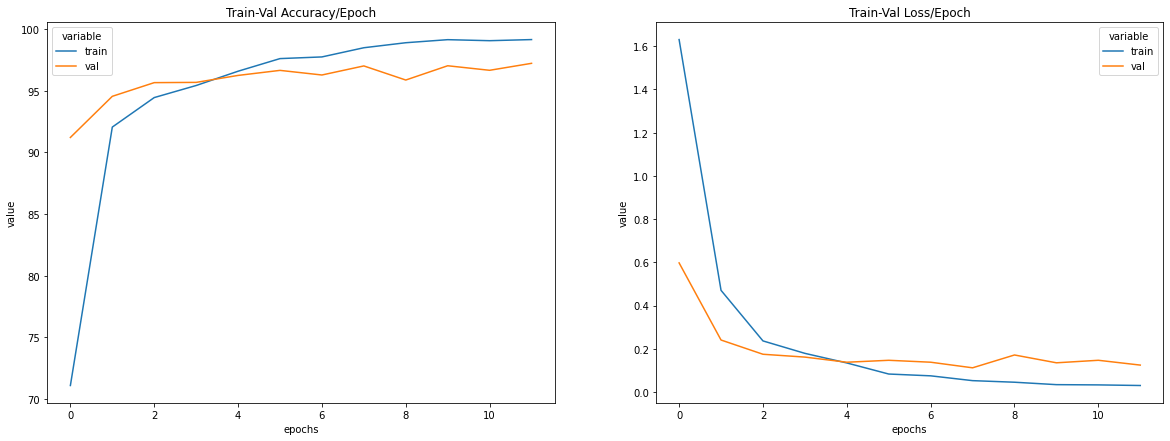

In [28]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.95      0.97        38
           2       1.00      1.00      1.00       100
           3       0.88      0.92      0.90        25
           4       1.00      0.60      0.75         5
           5       0.88      0.78      0.83        46
           6       0.75      1.00      0.86         3
           7       0.89      0.94      0.92        18
           8       1.00      1.00      1.00        36
           9       1.00      0.97      0.99        38
          10       0.88      1.00      0.93         7
          11       0.95      0.95      0.95        43
          12       0.97      0.97      0.97        29
          13       1.00      1.00      1.00        19
          14       1.00      0.98      0.99        45
          15       0.97      0.97      0.97        34
          16       0.93      0.93      0.93        44
          17       0.97    

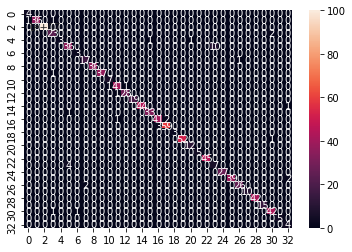

In [30]:
test_loader = DataLoader(dataset=test, batch_size=1, sampler=SubsetRandomSampler(np.arange(len(test))))
y_pred_list = []
y_test = []
with torch.no_grad():
    model.eval()
    for X_batch, y_test_batch in test_loader:
        y_test.append(y_test_batch)
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch.float())
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

# idx2class = {v: k for k, v in dataset.sample_to_labels.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))
sns.heatmap(confusion_matrix_df, annot=True)
print(classification_report(y_test, y_pred_list))